## Covid Analysis

In [164]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import datetime
from pathlib import Path

import keras as tk 
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation, Flatten, Add, add
from tensorflow.keras.layers import Input, InputLayer, Input, Conv2D, MaxPooling2D, AveragePooling2D, \
    GlobalAveragePooling2D, Activation, MaxPool2D, ZeroPadding2D, SeparableConv2D
#from keras.layers.normalization import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from keras import regularizers
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, CSVLogger

from keras.applications import DenseNet121, ResNet50
from keras.applications.vgg16 import VGG16

from sklearn import metrics

%reload_ext tensorboard

kernel_regularizer = regularizers.l2(0.0001)

final_activation = 'softmax'
entropy = 'sparse_categorical_crossentropy' # categorical_crossentropy
model_metric = 'sparse_categorical_accuracy' # sparse_categorical_
monitor_metric = 'val_sparse_categorical_accuracy' #'val_categorical_accuracy'
class_mode = 'sparse' # categorical
snapshots_dir = 'snapshots/'
history_dir = 'history/'
tenserboard_dir = 'logs/fit/'

seed = 100
epochs = 50
batch_size = 32
categories = ['Covid', 'Normal', 'Viral Pneumonia']
train_dir = './Covid19-dataset/train'
test_dir = './Covid19-dataset/test'
n_classes = len(categories)

img_width, img_height = 224, 224
input_shape=(img_width, img_height, 3)

datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          horizontal_flip=True,
                                                          brightness_range=[1.0,1.3],
                                                          rotation_range=15)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# !mkdir history

### Load and prepare data

In [117]:
def get_categories_df(dir):
    images = []
    for category in categories:
        files_path = os.path.join(dir, category)
        for path in Path(files_path).glob("*"):
            #print(path)
            images.append({"category": category, "file_name": os.path.join(*path.parts[-2:])})

    return pd.DataFrame(images).sample(frac = 1, random_state=seed)

train_df = get_categories_df(train_dir)
train_df

test_df = get_categories_df(test_dir)
test_df

,category,file_name
41,Normal,Normal/0115.jpeg
32,Normal,Normal/0117.jpeg
12,Covid,Covid/098.jpeg
57,Viral Pneumonia,Viral Pneumonia/0108.jpeg
58,Viral Pneumonia,Viral Pneumonia/0110.jpeg
...,...,...
23,Covid,Covid/0118.jpeg
39,Normal,Normal/0107.jpeg
3,Covid,Covid/auntminnie-b-2020_01_28_23_51_6665_2020_...
24,Covid,Covid/0106.jpeg


In [119]:
def get_iter(df, dir):
    return datagen.flow_from_dataframe(
        df,
        directory=dir,
        target_size=(img_width, img_height),
        x_col='file_name',
        y_col='category',
        batch_size=batch_size,
        class_mode=class_mode,
        color_mode="rgb",
        seed=seed,
        shuffle=False
    )

train_iter = get_iter(train_df, train_dir)

test_iter = get_iter(test_df, test_dir)

Found 251 validated image filenames belonging to 3 classes.
Found 66 validated image filenames belonging to 3 classes.


### Prepare Models

In [120]:
# https://www.kaggle.com/code/blurredmachine/alexnet-architecture-a-complete-guide
class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(96, kernel_size=(11,11), strides= 4,
                        padding= 'valid', activation= 'relu',
                        input_shape= input_shape,
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Conv2D(256, kernel_size=(5,5), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None)) 

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(384, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(Conv2D(256, kernel_size=(3,3), strides= 1,
                        padding= 'same', activation= 'relu',
                        kernel_initializer= 'he_normal'))

        self.add(MaxPooling2D(pool_size=(3,3), strides= (2,2),
                              padding= 'valid', data_format= None))

        self.add(Flatten())
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(4096, activation= 'relu'))
        self.add(Dense(1000, activation= 'relu'))
        self.add(Dense(num_classes, activation= 'softmax'))

        self.compile(optimizer= tf.keras.optimizers.Adam(0.001),
                    loss=entropy,
                    metrics=[model_metric])

In [121]:
def final_model(base_model):
    base_model.trainable = True
    
    top_model = Sequential()
    top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    top_model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
    top_model.add(BatchNormalization())
    top_model.add(Dropout(0.2, seed=seed))
    top_model.add(Dense(n_classes, activation='softmax'))

    model = Model(inputs=base_model.input, outputs=top_model(base_model.output))
    model.compile(loss=entropy,
                  optimizer='adam',
                  metrics=[model_metric])
    return model


def get_callbacks(model_name):
    log_dir= tenserboard_dir + model_name + "_" + datetime.datetime.now().strftime("%Y%m%d-Я%H%M%S")
    tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

    checkpoint_cb = ModelCheckpoint(snapshots_dir + model_name + "/{epoch:03d}-{" + monitor_metric + ":.5f}.weights.h5",
                                    monitor=monitor_metric,
                                    verbose=1,
                                    save_weights_only=True,
                                    save_best_only=True)
    
    es_cb = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    csv_cb = CSVLogger(history_dir + model_name + '_training.log', separator=',', append=False)
    
    return [tensorboard_cb, checkpoint_cb, es_cb, csv_cb]


def fit_model(model, model_name):
    history = model.fit(train_iter, 
                        epochs=epochs,
                        callbacks=get_callbacks(model_name),
                        validation_data = test_iter
                       )

    return model, history

def load_DenseNet121():
    input_tensor = Input(shape=input_shape)
    base_model = DenseNet121(pooling='avg',
                            include_top=False, 
                            input_tensor=input_tensor)
    
    model = final_model(base_model)
    return model

def load_VGG16():
    input_tensor = Input(shape=input_shape)
    base_model = VGG16(include_top=False,
                       weights='imagenet',
                       input_tensor=input_tensor)
    
    model = final_model(base_model)
    return model

def load_ResNet50():
    input_tensor = Input(shape=input_shape)
    base_model = ResNet50(pooling='avg',
                          include_top=False, 
                          input_tensor=input_tensor)
    
    model = final_model(base_model)
    return model

def load_AlexNet():
    return AlexNet((img_width, img_height, 3), n_classes)

### Fit models

In [122]:
dense_model = load_DenseNet121()
dense_model, dense_history = fit_model(dense_model, 'DenseNet121')

vgg_model = load_VGG16()
vgg_model, vgg_history = fit_model(vgg_model, 'VGG16')

resnet_model = load_ResNet50()
resnet_model, resnet_history = fit_model(resnet_model, 'ResNet50')

alexnet_model = load_AlexNet()
alexnet_model, alexnet_history = fit_model(resnet_model, 'AlexNet')

Epoch 1/50
8/8 [==============================] - ETA: 0s - loss: 0.5908 - sparse_categorical_accuracy: 0.7769 
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.30303, saving model to snapshots/DenseNet121/001-0.30303.weights.h5
8/8 [==============================] - 156s 12s/step - loss: 0.5908 - sparse_categorical_accuracy: 0.7769 - val_loss: 3.0393 - val_sparse_categorical_accuracy: 0.3030
Epoch 2/50
8/8 [==============================] - ETA: 0s - loss: 0.2789 - sparse_categorical_accuracy: 0.9084
Epoch 2: val_sparse_categorical_accuracy improved from 0.30303 to 0.37879, saving model to snapshots/DenseNet121/002-0.37879.weights.h5
8/8 [==============================] - 84s 10s/step - loss: 0.2789 - sparse_categorical_accuracy: 0.9084 - val_loss: 2.5163 - val_sparse_categorical_accuracy: 0.3788
Epoch 3/50
8/8 [==============================] - ETA: 0s - loss: 0.3270 - sparse_categorical_accuracy: 0.8845
Epoch 3: val_sparse_categorical_accuracy did not improve from 0.

### Evaluate Models

In [167]:
# %tensorboard --logdir logs/fit  --host localhost

In [123]:
model_names = ['DenseNet121', 'VGG16', 'ResNet50', 'AlexNet']
               
def load_saved_model(model_name):
    model = globals()['load_' + model_name]()
    checkpoints_dir = snapshots_dir + model_name
    best_weights = sorted(os.listdir(snapshots_dir + model_name), reverse=True)[0]
    print(best_weights)
    model.load_weights(checkpoints_dir + '/' + best_weights, skip_mismatch=True)
    return model

def load_saved_history(model_name):
    return  pd.read_csv(history_dir + model_name + '_training.log')

    return model, history_df

#### Model accuracy

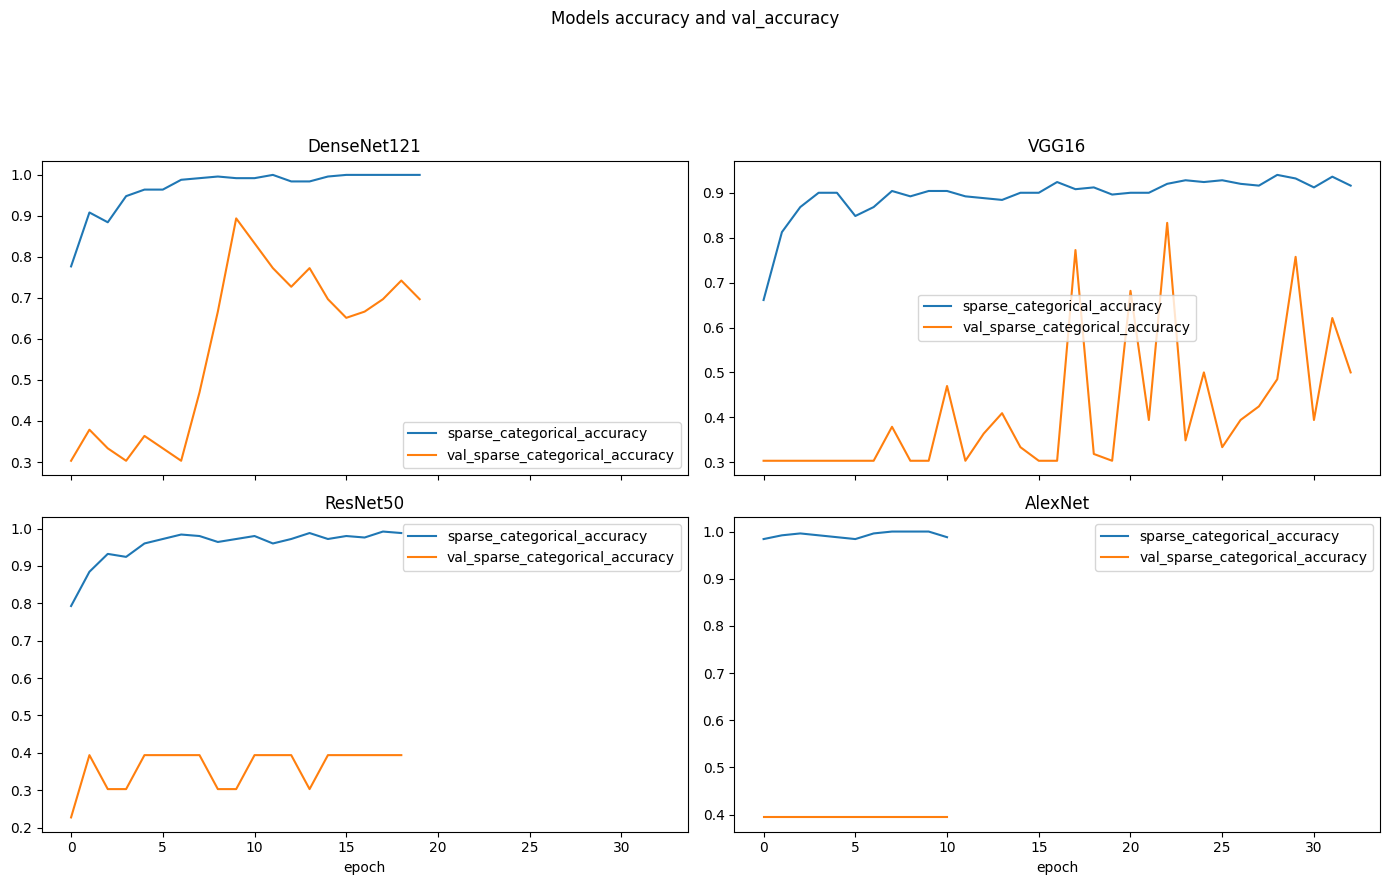

In [124]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True)

for cat, ax in enumerate(axes.flatten()):
    model_name = model_names[cat]
    df = load_saved_history(model_name)
    df.plot(ax=ax, x='epoch', y=['sparse_categorical_accuracy', 'val_sparse_categorical_accuracy'], title=model_name)

# Plot meta data
fig.suptitle("Models accuracy and val_accuracy", y=1.1)
fig.tight_layout()

#### Best model confusion matrix

In [125]:
best_model = load_saved_model("VGG16")

023-0.83333.weights.h5


In [126]:
best_model.evaluate(test_iter)

3/3 [==============================] - 15s 3s/step - loss: 0.5315 - sparse_categorical_accuracy: 0.8030


[0.5315355062484741, 0.8030303120613098]

In [129]:
predictions = best_model.predict(test_iter, verbose=1)
preds = np.argmax(predictions, axis=1)

3/3 [==============================] - 12s 3s/step


Accuracy 0.77


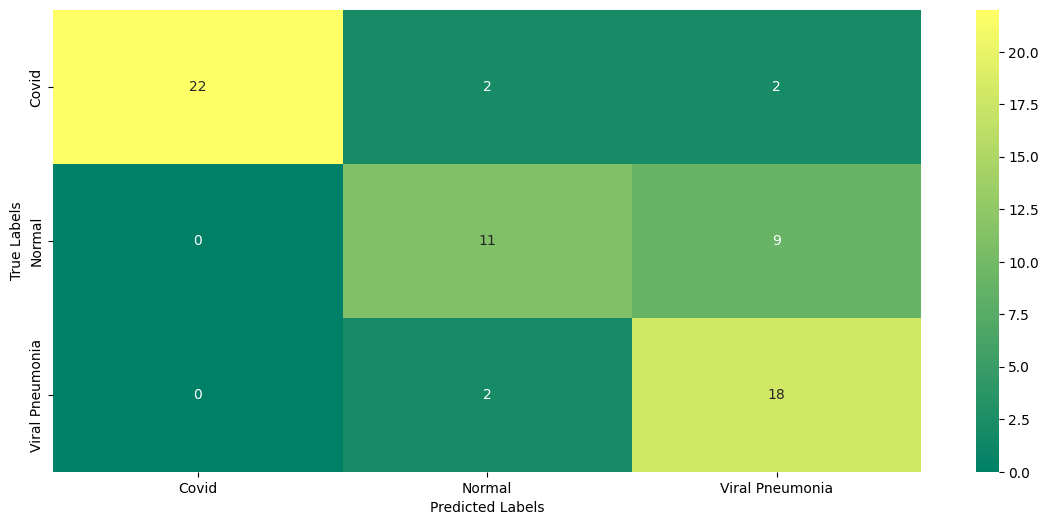

In [130]:
y_test = test_iter.labels
print('Accuracy %.2f' % metrics.accuracy_score(y_test, preds))

categories = test_iter.class_indices.keys()
    
plt.figure(figsize = (14,6))
sns.heatmap(metrics.confusion_matrix(y_test, preds), annot = True, fmt="d",
            xticklabels = categories, yticklabels = categories, cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Research errors

In [131]:
def get_model_predictions(model_name):
    model = load_saved_model(model_name)
    predictions = best_model.predict(test_iter, verbose=1)
    return np.argmax(predictions, axis=1)

In [132]:
test_df2 = test_df.copy()
test_df2['labels'] = test_iter.labels

In [147]:
for model_name in ['DenseNet121', 'VGG16', 'ResNet50', 'AlexNet']:
    test_df2[model_name] = get_model_predictions(model_name)
    print('Accuracy %s %.2f' % (model_name, metrics.accuracy_score(test_df2['labels'], test_df2[model_name])))

010-0.89394.weights.h5


3/3 [==============================] - 12s 2s/step
Accuracy DenseNet121 0.80
023-0.83333.weights.h5


3/3 [==============================] - 11s 2s/step
Accuracy VGG16 0.82
002-0.39394.weights.h5


3/3 [==============================] - 11s 3s/step
Accuracy ResNet50 0.83


001-0.39394.weights.h5
3/3 [==============================] - 11s 2s/step
Accuracy AlexNet 0.79


In [148]:
test_df2

,category,file_name,labels,DenseNet121,VGG16,ResNet50,AlexNet
41,Normal,Normal/0115.jpeg,1,2,2,1,2
32,Normal,Normal/0117.jpeg,1,1,1,1,2
12,Covid,Covid/098.jpeg,0,2,2,2,2
57,Viral Pneumonia,Viral Pneumonia/0108.jpeg,2,2,2,2,2
58,Viral Pneumonia,Viral Pneumonia/0110.jpeg,2,2,2,2,2
...,...,...,...,...,...,...,...
23,Covid,Covid/0118.jpeg,0,1,1,1,1
39,Normal,Normal/0107.jpeg,1,2,2,2,2
3,Covid,Covid/auntminnie-b-2020_01_28_23_51_6665_2020_...,0,0,0,0,0
24,Covid,Covid/0106.jpeg,0,0,0,0,0


#### Wrong predictions

In [149]:
wrong_preds_df = test_df2[(test_df2['labels'] != test_df2['DenseNet121']) & \
    (test_df2['labels'] != test_df2['VGG16']) & \
    (test_df2['labels'] != test_df2['ResNet50']) & \
    (test_df2['labels'] != test_df2['AlexNet'])]

In [150]:
wrong_preds_df = wrong_preds_df.reset_index()
wrong_preds_df['category'].value_counts()

category
Covid     3
Normal    2
Name: count, dtype: int64

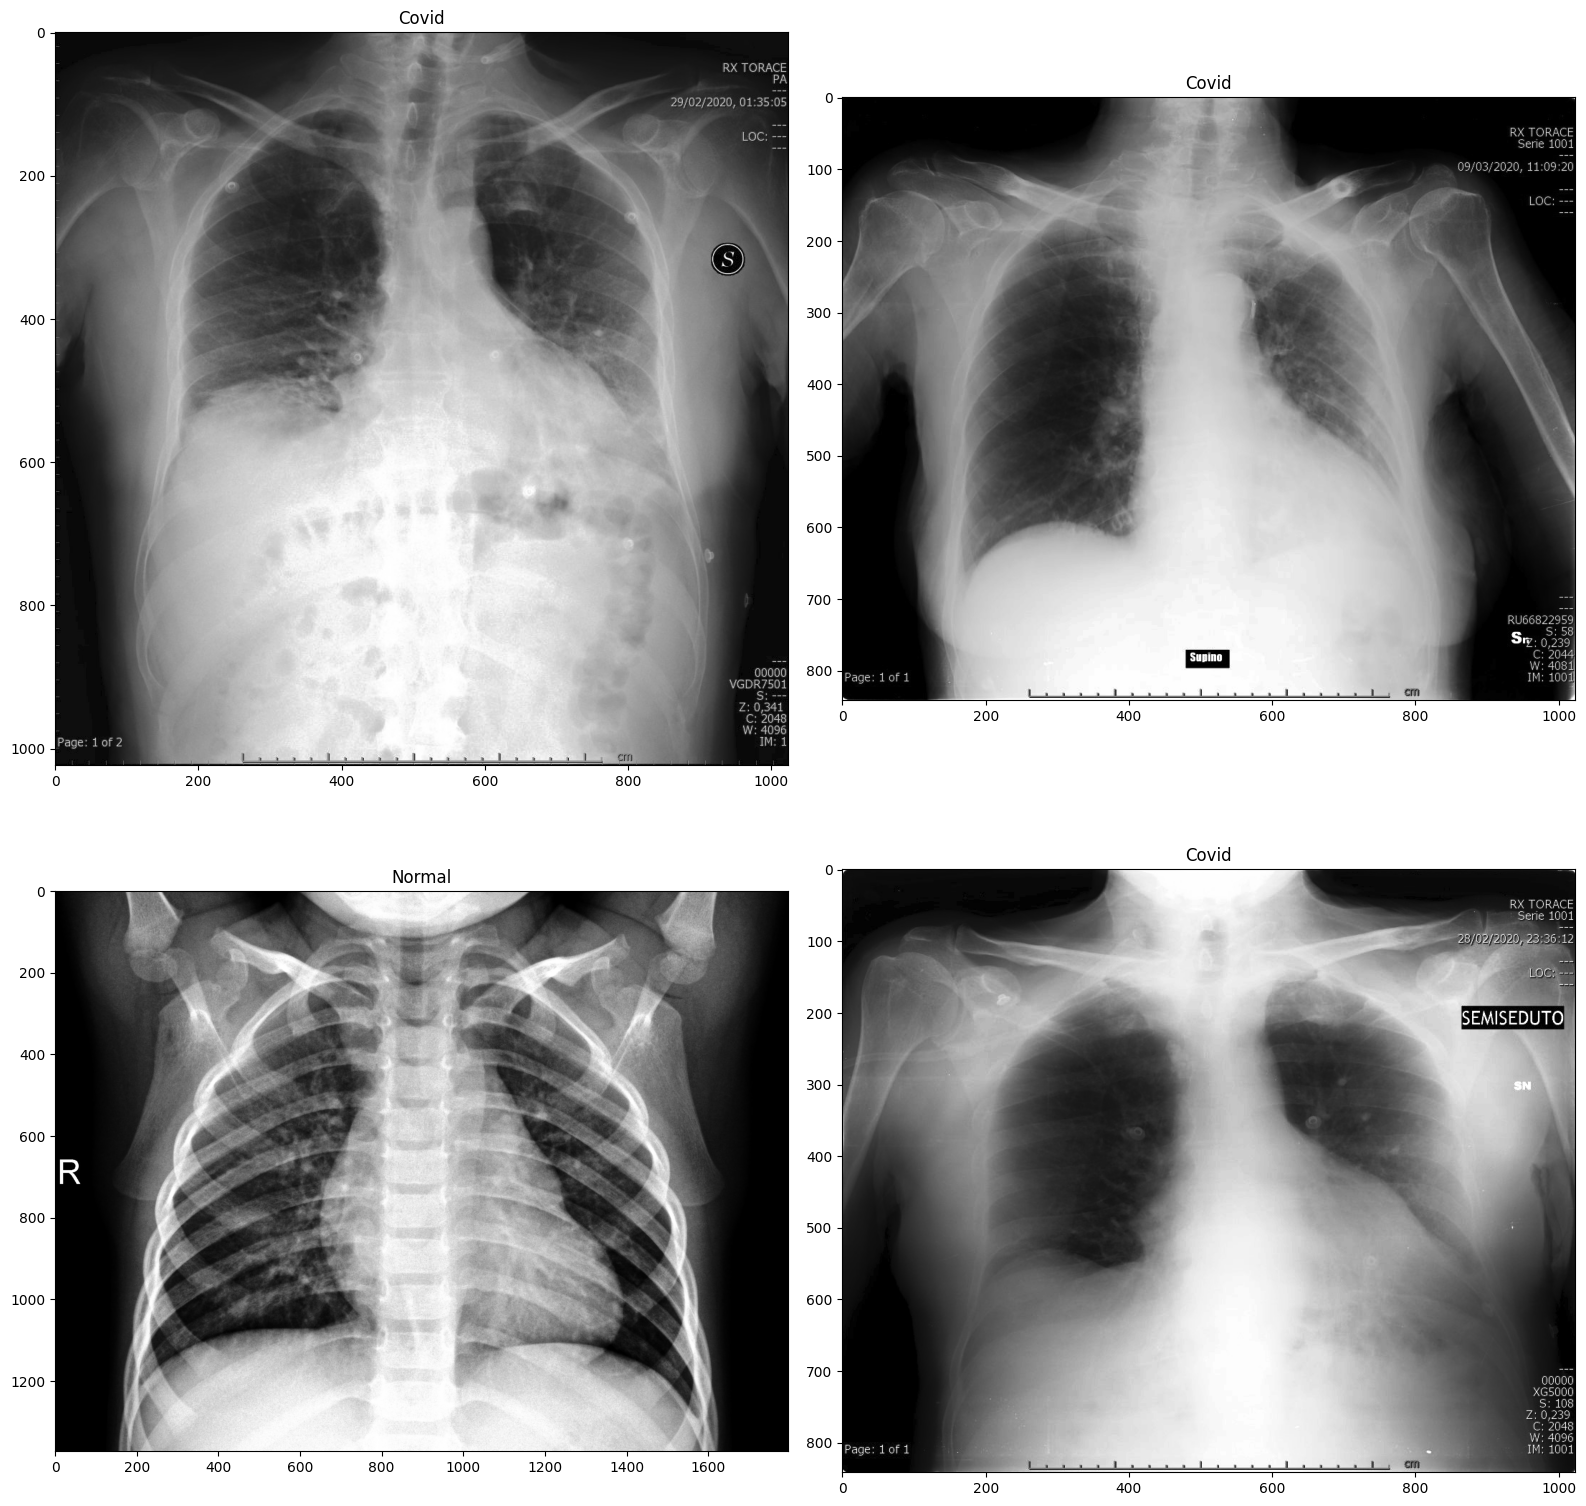

In [151]:
fig, ax=plt.subplots(2, 2)
fig.set_size_inches(16, 16)

ind = 0
for i in range(2):
    for j in range (2):
            img_path = test_dir + '/' + wrong_preds_df.loc[ind, 'file_name']
            ax[i,j].imshow(plt.imread(img_path))
            ax[i,j].set_title(wrong_preds_df.loc[ind, 'category'])
            ind = ind +1
        
plt.tight_layout()

#### Correct predictions

In [152]:
correct_preds_df = test_df2[(test_df2['labels'] == test_df2['DenseNet121']) & \
    (test_df2['labels'] == test_df2['VGG16']) & \
    (test_df2['labels'] == test_df2['ResNet50']) & \
    (test_df2['labels'] == test_df2['AlexNet'])]

In [153]:
correct_preds_df = correct_preds_df.reset_index()
correct_preds_df['category'].value_counts()

category
Covid              21
Viral Pneumonia    20
Normal              6
Name: count, dtype: int64

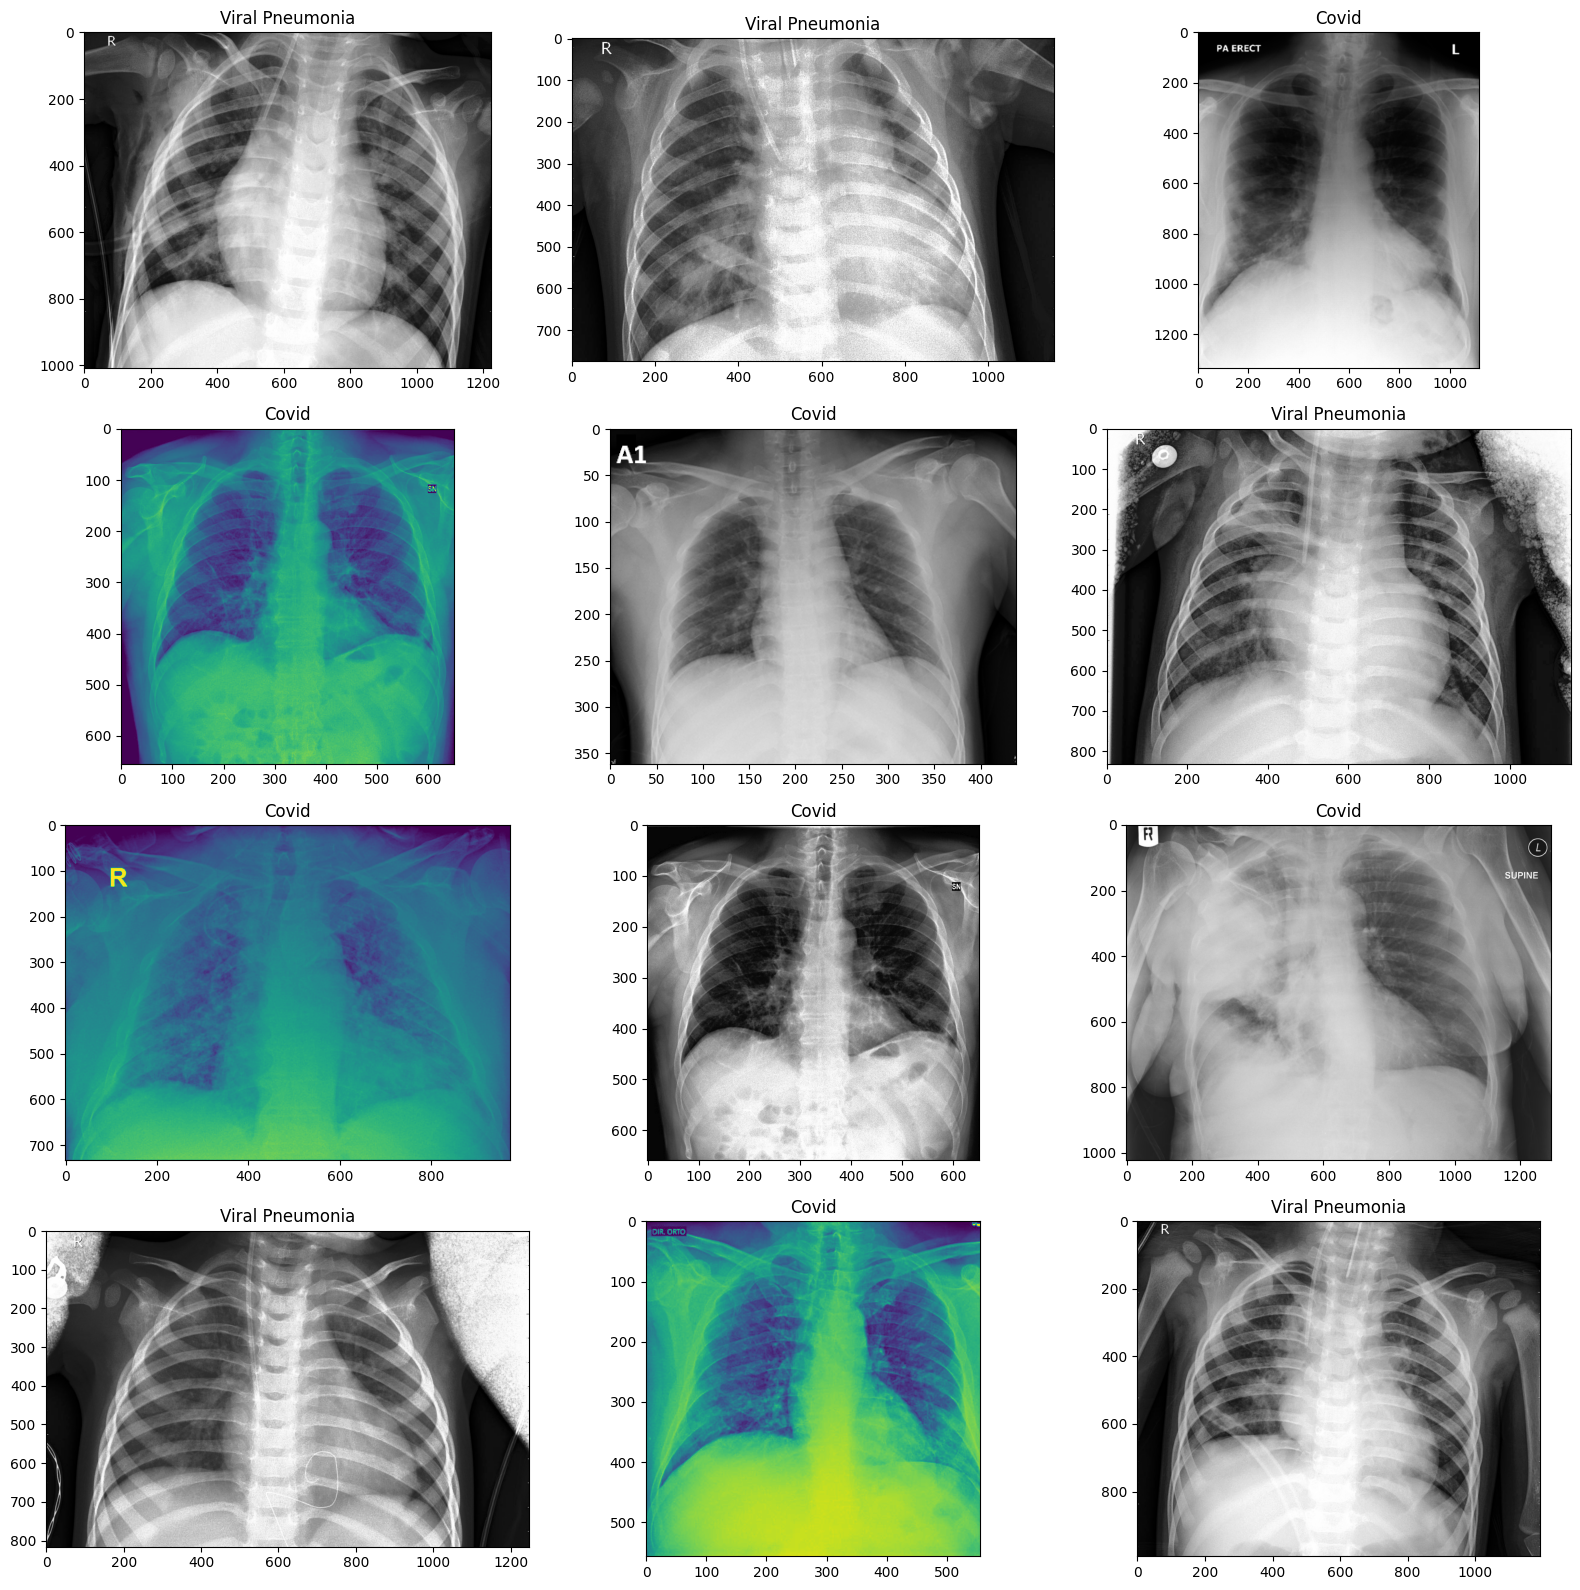

In [154]:
fig, ax=plt.subplots(4, 3)
fig.set_size_inches(16, 16)

ind = 0
for i in range(4):
    for j in range (3):
            img_path = test_dir + '/' + correct_preds_df.loc[ind, 'file_name']
            ax[i,j].imshow(plt.imread(img_path))
            ax[i,j].set_title(correct_preds_df.loc[ind, 'category'])
            ind = ind +1
        
plt.tight_layout()